In [9]:
import os
import joblib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from convsklearn import convsklearn

# functions

In [2]:
def compute_RMSE(diff):
    if len(diff)>0:
        return np.sqrt(np.mean(diff.values**2))
        
def compute_MAE(diff):
    if len(diff)>0:
        return np.mean(np.abs(diff.values))

def plot_errors(plotcols, test_data, train_data):
    test_diff = test_data['outofsample_error']
    train_diff = train_data['insample_error']
    
    test_data['RMSE'] = test_diff.resample('D').apply(compute_RMSE).dropna()
    test_data['MAE'] = test_diff.resample('D').apply(compute_MAE).dropna()
    test_plot = test_data[plotcols].copy().drop_duplicates()
    
    train_data['RMSE'] = train_diff.resample('D').apply(compute_RMSE).dropna()
    train_data['MAE'] = train_diff.resample('D').apply(compute_MAE).dropna()
    train_plot = train_data[plotcols].copy().drop_duplicates()
    
    trainx = pd.date_range(start=min(train_data.index),end=max(train_data.index),periods=train_plot.shape[0])
    testx = pd.date_range(start=min(test_data.index),end=max(test_data.index),periods=test_plot.shape[0])
    
    fig,axs = plt.subplots(len(plotcols),figsize=(10,10),sharex=True)
    for i,col in enumerate(plotcols):
        axs[i].plot(trainx,train_plot[col],color='green',label='in-sample')
        axs[i].set_title(col.replace('_',' '))
        axs[i].legend()
    for i,col in enumerate(plotcols):
        axs[i].plot(testx,test_plot[col],color='purple',label='out-of-sample')
        axs[i].set_title(col.replace('_',' '))
        axs[i].legend()
    plt.show()

def retrain(train_data,test_data,retraining_frequency):
    retraining_i = np.arange(retraining_frequency,len(test_dates),retraining_frequency)
    retraining_dates = test_dates[retraining_i].reset_index(drop=True)
    print(f"retraining dates:\n{retraining_dates}")
    for i,date in enumerate(retraining_dates):
        if i<len(retraining_dates)-1:
            print()
            print(date.strftime('%c'))
            new_train = pd.concat([train_data,test_data[test_data.index<=date]],ignore_index=False).copy().dropna(how='any',axis=1).reset_index(drop=False)
            new_test = test_data[
                (test_data.index>date)
                # &(test_data.index<=retraining_dates[i+1])
            ].reset_index(drop=False)
            arrs = cvsk.get_train_test_arrays(new_train, new_test)
            train_X = arrs['train_X']
            train_y = arrs['train_y']
            test_X = arrs['test_X']
            test_y = arrs['test_y']
            preprocessor = cvsk.preprocess()
            retrained_model = cvsk.run_dnn(preprocessor,train_X,train_y)
            train_test = cvsk.test_prediction_accuracy(new_train,new_test,retrained_model)
            new_test_data = train_test['test_data'].set_index('calculation_date')
            new_train_data = train_test['train_data'].set_index('calculation_date')
            print()
            plot_errors(plotcols,new_test_data,new_train_data)
    return retrained_model

# loading model

In [3]:
from model_settings import ms
root = Path().resolve().parent.parent
models_dir = os.path.join(root,ms.trained_models)
models = pd.Series([f for f in os.listdir(models_dir) if f.find('.')==-1]
for i,m in enumerate(models):
    print(f"{i}     {m}")

0     2024_11_01 204910611379 bloomberg barriers
1     2024_11_01 205356527985 bloomberg asians
2     2024_11_05 184958719691 Oosterlee test


# loading data

In [4]:
"""
select model here
"""
model = models[-1]
""""""

plotcols = ['v0','RMSE', 'MAE','spot_price']

from convsklearn import asian_trainer, barrier_trainer

model_dir = os.path.join(models_dir,model)

model_files = [f for f in os.listdir(model_dir) if f.find('ipynb')==-1 and f.find('.html')==-1]
model_fit = joblib.load(os.path.join(model_dir,[f for f in model_files if f.endswith('.pkl')][0]))
train_data = pd.read_csv(os.path.join(model_dir,[f for f in model_files if f.find('train')!=-1][0])).iloc[:,1:].copy()
test_data = pd.read_csv(os.path.join(model_dir,[f for f in model_files if f. find('test')!=-1][0])).iloc[:,1:].copy()

model_fit.__dict__

{'regressor': Pipeline(steps=[('columntransformer',
                  ColumnTransformer(transformers=[('scaling', StandardScaler(),
                                                   ['relative_moneyness',
                                                    'days_to_maturity',
                                                    'risk_free_rate',
                                                    'dividend_rate', 'kappa',
                                                    'theta', 'rho', 'eta', 'v0',
                                                    'relative_barrier']),
                                                  ('encoding', OneHotEncoder(),
                                                   ['w',
                                                    'barrier_type_name'])])),
                 ('mlpregressor',
                  MLPRegressor(max_iter=1000, random_state=1312, solver='sgd'))]),
 'transformer': Pipeline(steps=[('scaling', StandardScaler())]),
 'func': None,
 'inver

In [5]:
train_data['calculation_date'] = pd.to_datetime(train_data['calculation_date'],format='mixed').dt.normalize()
test_data['calculation_date'] = pd.to_datetime(test_data['calculation_date'],format='mixed').dt.normalize()
train_data = train_data.set_index('calculation_date')
test_data = test_data.set_index('calculation_date')
test_dates = pd.Series(test_data.index).sort_values(ascending=True).drop_duplicates().reset_index(drop=True)
test_data['outofsample_prediction'] = model_fit.predict(test_data[model_fit.feature_names_in_])
test_data['outofsample_error'] = test_data['relative_price'] - test_data['outofsample_prediction']
train_data['insample_prediction'] = model_fit.predict(test_data[model_fit.feature_names_in_])
train_data['insample_error'] = model_fit.predict(train_data[model_fit.feature_names_in_])

relative moneyness: 
0     -0.1
1     -0.1
2     -0.1
3     -0.1
4     -0.1
      ... 
392    0.1
393    0.1
394    0.1
395    0.1
396    0.1
Name: relative_moneyness, Length: 397, dtype: float64

days to maturity: 
0     60.0
1     90.0
2    180.0
3    360.0
4    540.0
5    720.0
Name: days_to_maturity, dtype: float64

risk free rate: 
0    0.04
Name: risk_free_rate, dtype: float64

dividend rate: 
0    0.0
Name: dividend_rate, dtype: float64

kappa: 
0       7.382203e-08
1       9.363197e-04
2       1.055340e-03
3       1.226778e-03
4       1.331520e-03
            ...     
3262    2.956149e+02
3263    3.237616e+02
3264    3.278052e+02
3265    3.300095e+02
3266    3.640252e+02
Name: kappa, Length: 3267, dtype: float64

theta: 
0       8.139494e-07
1       3.108355e-02
2       3.510920e-02
3       3.521398e-02
4       3.811586e-02
            ...     
3262    5.116187e+01
3263    5.418347e+01
3264    5.835947e+01
3265    6.469805e+01
3266    1.003311e+02
Name: theta, Length: 3267, dty

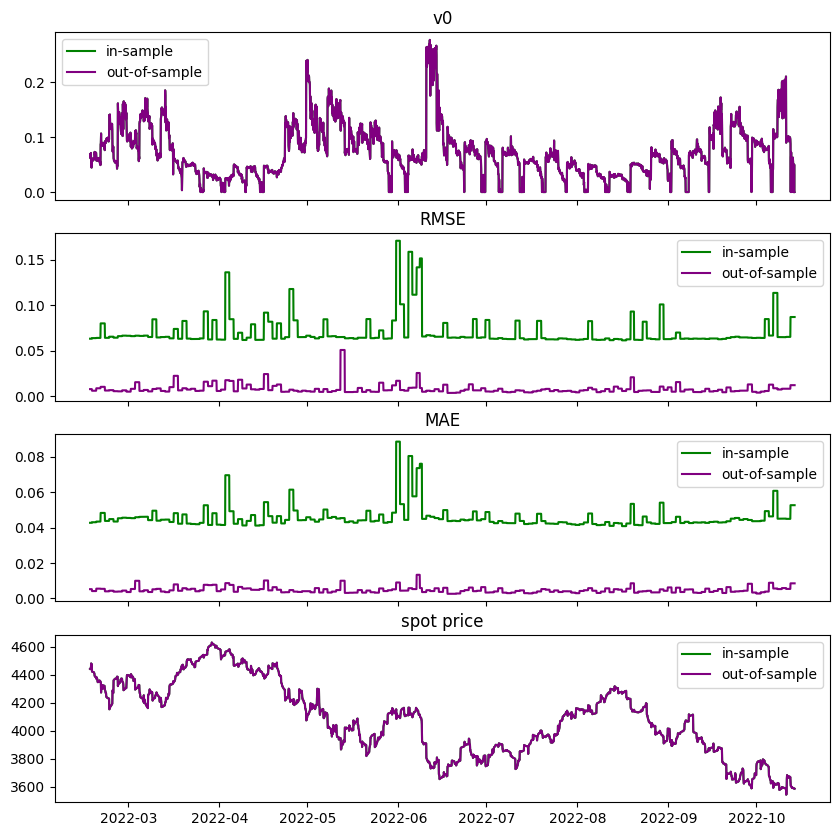

,spot_price,strike_price,barrier,days_to_maturity,updown,outin,w,barrier_type_name,rebate,dividend_rate,...,barrier_price,observed_price,moneyness,relative_moneyness,relative_barrier,relative_price,outofsample_prediction,outofsample_error,RMSE,MAE
calculation_date,,,,,,,,,,,,,,,,,,,,,
2022-02-16,4441.75,3997.575,2220.875,60.0,Down,Out,call,DownOut,0.0,0.0,...,515.613589,515.610834,444.175,0.1,0.5,0.116083,0.116346,-0.000263,0.007559,0.005196
2022-02-16,4441.75,3997.575,2220.875,60.0,Down,Out,put,DownOut,0.0,0.0,...,37.861034,37.896135,-444.175,-0.1,0.5,0.008532,0.012249,-0.003717,0.007559,0.005196
2022-02-16,4441.75,3997.575,2220.875,60.0,Down,In,call,DownIn,0.0,0.0,...,0.000000,0.029832,444.175,0.1,0.5,0.000007,0.002407,-0.002400,0.007559,0.005196
2022-02-16,4441.75,3997.575,2220.875,60.0,Down,In,put,DownIn,0.0,0.0,...,7.031708,7.015353,-444.175,-0.1,0.5,0.001579,0.004490,-0.002910,0.007559,0.005196
2022-02-16,4441.75,3997.575,2220.875,90.0,Down,Out,call,DownOut,0.0,0.0,...,546.301779,546.297068,444.175,0.1,0.5,0.122991,0.123222,-0.000231,0.007559,0.005196
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-10-14,3586.50,3945.150,5379.750,540.0,Up,In,put,UpIn,0.0,0.0,...,17.514972,17.512228,358.650,0.1,1.5,0.004883,0.008809,-0.003927,0.011896,0.008491
2022-10-14,3586.50,3945.150,5379.750,720.0,Up,Out,call,UpOut,0.0,0.0,...,51.618563,51.612386,-358.650,-0.1,1.5,0.014391,0.027387,-0.012996,0.011896,0.008491
2022-10-14,3586.50,3945.150,5379.750,720.0,Up,Out,put,UpOut,0.0,0.0,...,636.430811,636.419099,358.650,0.1,1.5,0.177449,0.131120,0.046328,0.011896,0.008491


In [6]:
for col in model_fit.feature_names_in_:
    print(f"{col.replace("_"," ")}:",f"\n{test_data[col].copy().squeeze().sort_values().drop_duplicates().reset_index(drop=True)}\n")
print()
print(model_fit)

plot_errors(plotcols, test_data, train_data)
test_data

In [7]:
test_data.columns

Index(['spot_price', 'strike_price', 'barrier', 'days_to_maturity', 'updown',
       'outin', 'w', 'barrier_type_name', 'rebate', 'dividend_rate',
       'risk_free_rate', 'theta', 'kappa', 'rho', 'eta', 'v0', 'date',
       'barrier_price', 'observed_price', 'moneyness', 'relative_moneyness',
       'relative_barrier', 'relative_price', 'outofsample_prediction',
       'outofsample_error', 'RMSE', 'MAE'],
      dtype='object')

# retraining

In [8]:
retrained_model = retrain(train_data=train_data,test_data=test_data,trainer=model_fit,retraining_frequency=30)

TypeError: retrain() missing 1 required positional argument: 'trainer'